# Test Case 1

Plane wave reflection coefficient, $\varphi_g$ (angle between source and ground). $\alpha=\pi/2-\varphi_g$.

$$R_p(\alpha)=\frac{p_r}{p_i}=\frac{Z_s\cos(\alpha)-\rho c}{Z_s\cos(\alpha)+\rho c}$$

Delaney and Bazley model.

$$Z_s=\rho c\Bigg(1+9.08\Bigg(\frac{1000f}{\sigma}\Bigg)^{-0.75}-j11.9\Bigg(\frac{1000f}{\sigma}\Bigg)^{-0.73}\Bigg)$$

where $c=20.05\sqrt{273.15+t_0}$, being $t_0$ the measured temperature in celsius. The flow resistivity $\sigma$ is given in [Ns/m$^4$]

The total sound pressure at the receiver is

$$P_t=S\Bigg(\frac{H_1}{r_1}+\frac{H_2}{r_2}R_p\Bigg)$$

We need to isolate real and imaginary parts (STAN doesn't support complex solutions yet). Therefore we will have for each frequency band

$$P_t=(S_r+jS_i)\Bigg(\frac{1}{r_1}(H_{1r}+jH_{1i})+\frac{1}{r_2}(H_{2r}+jH_{2i})(R_{pr}+jR_{pi})\Bigg)=$$
$$= (S_r+jS_i)\Bigg(\frac{H_{1r}+jH_{1i}}{r_1}+\frac{1}{r_2}(H_{2r}R_{pr}+jH_{2r}R_{pi}+jH_{2i}R_{pr}-H_{2i}R_{pi})\Bigg)=$$
$$=\Bigg(\frac{1}{r_1}(S_rH_{1r}+jS_rH_{1i}+jS_iH_{1r}-S_iH_{1i})+\frac{1}{r_2}(S_rH_{2r}R_{pr}+jS_rH_{2r}R_{pi}+jS_rH_{2i}R_{pr}-S_rH_{2i}R_{pi}+jS_iH_{2r}R_{pr}-S_iH_{2r}R_{pi}-S_iH_{2i}R_{pr}-jS_iH_{2i}R_{pi})\Bigg)$$

Real and imaginary

$$\text{Re}(P_t)=\Bigg(\frac{1}{r_1}(S_rH_{1r}-S_iH_{1i})+\frac{1}{r_2}(S_rH_{2r}R_{pr}-S_rH_{2i}R_{pi}-S_iH_{2r}R_{pi}-S_iH_{2i}R_{pr})\Bigg)$$
$$\text{Im}(P_t)=\Bigg(\frac{1}{r_1}(S_rH_{1i}+S_iH_{1r})+\frac{1}{r_2}(S_rH_{2r}R_{pi}+S_rH_{2i}R_{pr}+S_iH_{2r}R_{pr}-S_iH_{2i}R_{pi})\Bigg)$$

The surface impedance then can be defined as

$$Z_s=\rho c(A+jB)$$

and the reflection coefficient

$$R_p=\frac{(A+jB)\cos(\alpha)-1}{(A+jB)\cos(\alpha)+1}=\frac{A\cos(\alpha)-1+jB\cos(\alpha)}{A\cos(\alpha)+1+jB\cos(\alpha)}=\frac{[A\cos(\alpha)-1+jB\cos(\alpha)][A\cos(\alpha)+1-jB\cos(\alpha)]}{[A\cos(\alpha)+1+jB\cos(\alpha)][A\cos(\alpha)+1-jB\cos(\alpha)]}=\frac{(A\cos(\alpha))^2-1-jAB\cos^2(\alpha)+jB\cos(\alpha)+jAB\cos^2(\alpha)+jB\cos(\alpha)+(B\cos(\alpha))^2}{(A\cos(\alpha)+1)^2+(B\cos(\alpha))^2}=\frac{(A\cos(\alpha))^2-1+(B\cos(\alpha))^2+j(2B\cos(\alpha))}{(A\cos(\alpha)+1)^2+(B\cos(\alpha))^2}=\frac{(A^2-B^2)\cos^2(\alpha)-1+j2B\cos(\alpha)}{(A\cos(\alpha)+1)^2+(B\cos(\alpha))^2}$$

Real and imaginary

$$\text{Re}(R_p)=R_{pr}=\frac{(A^2-B^2)\cos^2(\alpha)-1}{(A\cos(\alpha)+1)^2+(B\cos(\alpha))^2}$$
$$\text{Im}(R_p)=R_{pi}=\frac{2B\cos(\alpha)}{(A\cos(\alpha)+1)^2+(B\cos(\alpha))^2}$$

where

$$A=1+9.08\Bigg(\frac{1000f}{\sigma}\Bigg)^{-0.75}$$
$$B=-11.9\Bigg(\frac{1000f}{\sigma}\Bigg)^{-0.73}$$

For the simplest case where $S=H_1=H_2=1$, we have

$$\text{Re}(P_t)=\frac{1}{r_1}+\frac{1}{r_2}(R_{pr})$$
$$\text{Im}(P_t)=\frac{1}{r_2}(R_{pi})$$

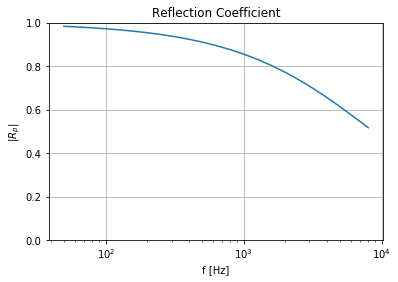

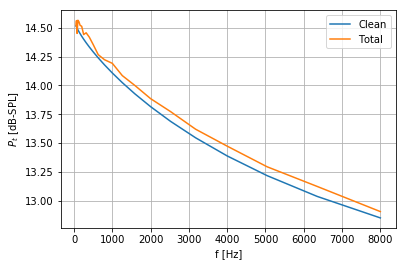

In [10]:
#INITIALIZATION
from __future__ import division
import numpy as np
import scipy as sc
import pystan
from psis import psisloo
import angle2segments as a2s
import math
%matplotlib inline
import matplotlib.pyplot as plt

# Define problem variables
## Fequencies
n = 23;
f = np.zeros(n, dtype=np.float)
f[n-1] = 8000;
pref = 20*np.exp(-6);
for i in np.arange(0,n-1):
    f[n-2-i] = f[n-1-i]/2**(1/3)
## Coordinates
s = [1, 6]
si = [s[0],-s[1]]
r = [1, 2]
r1 = np.linalg.norm(np.subtract(s,r))
r2 = np.linalg.norm(np.subtract(si,r))
## Find angle of incidence
alpha = math.pi/2-math.acos(np.abs(r[0]-s[0])/r2)
## Flow resistivity, impedance...
sigma = 420000
T = 25
c = 20.05*np.sqrt(273.15+T)
rho = 1.2
Zs = (1+9.08*(1000*f/sigma)**(-0.75)-11.9j*(1000*f/sigma)**(-0.73))
Rp = (Zs*np.cos(alpha)-1)/(Zs*np.cos(alpha)+1)
## Signal and source responses
S = np.ones(n, dtype=np.float)
H1 = np.ones(n, dtype=np.float)
H2 = np.ones(n, dtype=np.float)
## Total pressure
pt_clean = S*(H1/r1+Rp*H2/r2)
## Noise
SNR = 40
An = abs(pt_clean/10**(SNR/20))
Phin = np.random.normal(0,1,len(f))

pt = pt_clean+An*np.exp(1j*Phin)
pt_real = np.real(pt)
pt_imag = np.imag(pt)


plt.plot(f,np.abs(Rp))
plt.xscale('log')
plt.grid()
plt.xlabel('f [Hz]')
plt.ylabel(r'$|R_p|$')
plt.ylim(0,1)
plt.title(r'Reflection Coefficient')
plt.show()
plt.figure()
#plt.plot(f,20*np.log10(abs(An/np.sqrt(2)/pref)))
plt.plot(f,20*np.log10(abs(pt_clean/np.sqrt(2)/pref)))
plt.plot(f,20*np.log10(abs(pt/np.sqrt(2)/pref)))
plt.legend(['Clean', 'Total'])
plt.xlabel('f [Hz]')
plt.ylabel(r'$P_t$ [dB-SPL]')
plt.grid()

<p>The parameters that we can measure are.
1. Total pressure: $P_t$.
2. Temperature: $T$. Accuracy $\pm 0.2^{\circ}$C (Vaisala WTS520).
3. Distances: $r_1$ and $r_2$. Accuracy $\pm 0.015$ m. Maybe model the accuracy of the DEM.
4. Flow resistivity: $\sigma$. Nord2000 and Nordtest ranges. In this case, lets assume the case of compacted field and gravel $\rightarrow$ 500 [kNs/m$^4$] and a range of [400-630].
5. Directivity and source signals: Equal to one.

<p> We have to model two different problems for real and imaginary parts.


In [3]:
# Known data from sensors and forward model (deviation, etc...)
T_dev = 0.2
r_dev = 0.015
sigma_mean = 500000
sigma_dev = 130000
# Measured data with errors (Synthetic data)
Tm = T #np.random.normal(T, T_dev)
sm = np.random.normal(s, r_dev);
rm = np.random.normal(r, r_dev);
D = len(rm) # Dimensions
sm

array([ 1.00294797,  6.00561239])

## Priors

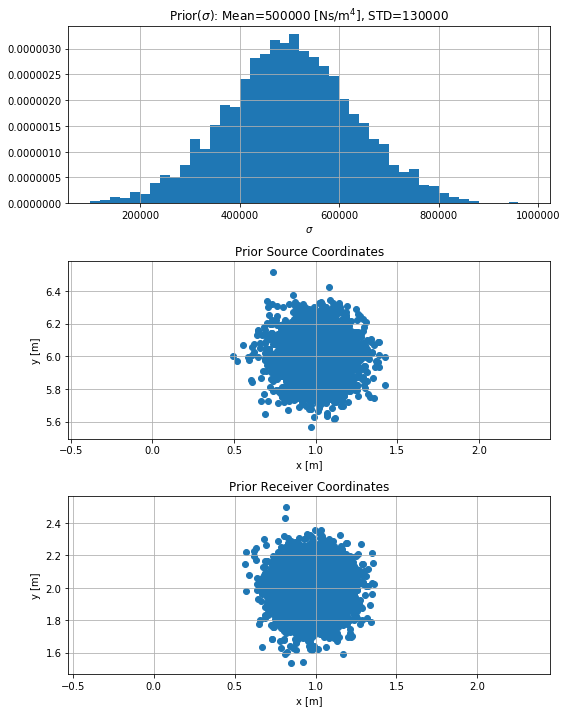

In [4]:
#samples = fit.extract(permuted=True)
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.hist(np.random.normal(sigma_mean,sigma_dev,4000),normed=True,bins=np.arange(100000, 1000000, 20000))
plt.title(r'Prior($\sigma$): Mean='+str(sigma_mean)+' [Ns/m$^4$], STD='+str(sigma_dev))
plt.grid()
plt.xlabel(r'$\sigma$')
cov = [[r_dev, 0],[0 ,r_dev]]
x = np.random.multivariate_normal(sm,cov,4000)
plt.subplot(3,1,2)
plt.scatter(x[:,0],x[:,1])
plt.axis('equal')
plt.title(r'Prior Source Coordinates')
plt.xlabel(r'x [m]')
plt.ylabel(r'y [m]')
plt.grid()
plt.subplot(3,1,3)
x = np.random.multivariate_normal(rm,cov,4000)
plt.scatter(x[:,0],x[:,1])
plt.axis('equal')
plt.title(r'Prior Receiver Coordinates')
plt.xlabel(r'x [m]')
plt.ylabel(r'y [m]')
plt.grid()
plt.show
plt.tight_layout()

## Model Sigma and coordinates (It works)

In [5]:
data = dict(N=len(f), 
            D=D, 
            f=f, 
            pt_real=pt_real, 
            pt_imag=pt_imag, 
            T=Tm, 
            T_dev=T_dev, 
            rho=rho, 
            r=r,
            r_mean=rm,
            s_mean=sm, 
            r_dev=r_dev,
            sigma_mean=sigma, 
            sigma_dev=sigma_dev,
           alpha=alpha)
reflection_coef = """
data {
    int<lower=0> N; // number of frequencies
    int<lower=0> D; // Dimensions
    vector[D] s_mean; // Coordinates source. Prior mean
    vector[D] r_mean; // Coordinates receiver. Prior mean
    vector[N] pt_real; // Pressure at receiver. Real part
    vector[N] pt_imag; // Pressure at receiver. Imaginary part
    vector[N] f; // frequencies
    real T; // Temperature. Prior mean
    real r_dev; // Distance deviation
    real sigma_mean; // Nordtest approximation. Prior mean
    real sigma_dev; // Sigma deviation
    real rho; // density
}
parameters {
    real<lower=0> sigma; // Flow resistivity greater than 0
    vector[D] s; // coordinates source
    vector[D] r; // coordinates receiver
    real epsilon_real; // variance of the banckground noise
    real epsilon_imag; // variance of the banckground noise
}
transformed parameters {
    vector[N] A;
    vector[N] B;
    vector[N] Rpr;
    vector[N] Rpi;
    vector[N] den;
    vector[N] mu_real;
    vector[N] mu_imag;
    real r1;
    real r2;
    real alpha;
    
    r1 = sqrt((s[1]-r[1])^2+(s[2]-r[2])^2);
    r2 = sqrt((s[1]-r[1])^2+(-s[2]-r[2])^2);
    alpha = pi()/2-atan(fabs(s[2]+r[2])/fabs(s[1]-r[1]));
    
    for (n in 1:N){
        A[n] = 1+9.08*(1000*f[n]/sigma)^(-0.75);
        B[n] = -11.9*(1000*f[n]/sigma)^(-0.73);
        den[n] = (A[n]*cos(alpha)+1)^2+(B[n]*cos(alpha))^2;
        Rpr[n] = ((A[n]^2-B[n]^2)*cos(alpha)^2-1)/den[n];
        Rpi[n] = (2*B[n]*cos(alpha)^2)/den[n];
        mu_real[n] = 1/r1+1/r2*Rpr[n];
        mu_imag[n] = 1/r2*Rpi[n];
        }
}
model {
    sigma ~ normal(sigma_mean, sigma_dev);
    for (n in 1:D){
        s[n] ~ normal(s_mean[n],r_dev);
        r[n] ~ normal(r_mean[n],r_dev);
        }
    for (n in 1:N){
      pt_real[n] ~ normal(mu_real[n], epsilon_real);
      pt_imag[n] ~ normal(mu_imag[n], epsilon_imag);
      }
}
"""

fit = pystan.stan(model_code=reflection_coef, data=data)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b15c8acc0f6d39a4173043e4177b68f NOW.


In [6]:
samples = fit.extract(permuted=True)

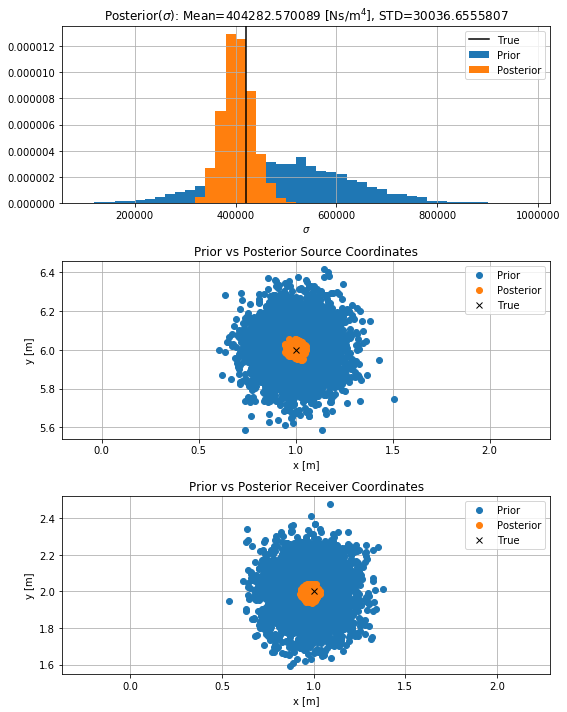

In [7]:
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.hist(np.random.normal(sigma_mean,sigma_dev,4000),normed=True,bins=np.arange(100000, 1000000, 20000))
plt.hist(fit['sigma'],bins=np.arange(100000, 1000000, 20000),normed=True)
plt.axvline(x=sigma,color='k')
plt.title(r'Posterior($\sigma$): Mean='+str(np.mean(fit['sigma']))+' [Ns/m$^4$], STD='+str(np.std(fit['sigma'])))
plt.grid()
plt.xlabel(r'$\sigma$')
plt.legend(['True','Prior','Posterior'])
cov = [[r_dev, 0],[0 ,r_dev]]
x = np.random.multivariate_normal(sm,cov,4000)
plt.subplot(3,1,2)
A,=plt.plot(x[:,0],x[:,1],'o')
B,=plt.plot(samples['s'][:,0],samples['s'][:,1],'o')
C,=plt.plot(s[0],s[1],'x', color='k')
plt.axis('equal')
plt.title(r'Prior vs Posterior Source Coordinates')
plt.xlabel(r'x [m]')
plt.ylabel(r'y [m]')
plt.legend([A,B,C],['Prior','Posterior','True'])
plt.grid()
plt.subplot(3,1,3)
x = np.random.multivariate_normal(rm,cov,4000)
A,=plt.plot(x[:,0],x[:,1],'o')
B,=plt.plot(samples['r'][:,0],samples['r'][:,1],'o')
C,=plt.plot(r[0],r[1],'x', color='k')
plt.axis('equal')
plt.title(r'Prior vs Posterior Receiver Coordinates')
plt.xlabel(r'x [m]')
plt.ylabel(r'y [m]')
plt.legend([A,B,C],['Prior','Posterior','True'])
plt.grid()
plt.show
plt.tight_layout()

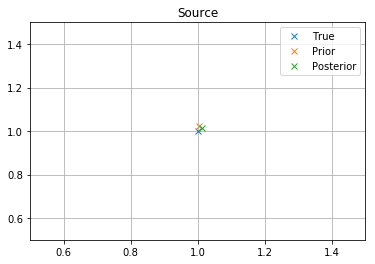

In [173]:
A,=plt.plot(s[0],s[1],'x')
B,=plt.plot(sm[0],sm[1],'x')
C,=plt.plot(np.mean(fit['s'][0]),np.mean(fit['s'][1]),'x')
plt.grid()
plt.xlim(0.5,1.5)
plt.ylim(0.5,1.5)
plt.legend([A, B, C],['True', 'Prior', 'Posterior'])
plt.title('Source')

In [8]:
fit

Inference for Stan model: anon_model_7b15c8acc0f6d39a4173043e4177b68f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma         4.0e5  561.53  3.0e4  3.5e5  3.8e5  4.0e5  4.2e5  4.7e5   2862    1.0
s[0]            1.0  3.0e-4   0.02   0.97   0.99    1.0   1.01   1.03   2630    1.0
s[1]            6.0  2.8e-4   0.01   5.97   5.99    6.0   6.01   6.03   2924    1.0
r[0]           0.98  2.8e-4   0.02   0.95   0.97   0.98   0.99   1.01   3031    1.0
r[1]           1.99  2.6e-4   0.02   1.96   1.98   1.99    2.0   2.02   3387    1.0
epsilon_real   0.13  4.3e-4   0.02    0.1   0.11   0.13   0.14   0.17   2183    1.0
epsilon_imag 2.3e-3  6.7e-6 3.7e-4 1.7e-3 2.0e-3 2.3e-3 2.5e-3 3.2e-3   3088    nan
A[0]          44.77    0.05   2.44  40.25  43.18  44.64  46.32  50.02   2868    1.0
A[1]          37.81    0.04   2.05   34.0  36.47   37.7